In [1]:
import sys
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import logging


import torch
import torch.nn as nn
from torch import optim
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torch.utils.data import DataLoader

from IOU_computations import *
from Data_Handle.dataset_generator import Dataset_sat
from predict_and_evaluate import *
from Data_Handle.data_augmentation import *

from random import randint

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#to update in real time the notebook figures
%matplotlib notebook 

## Necessary parameters and Load model

#### WATCH OUT  Parameters should be set equal to the ones which has been trained the model with

In [3]:
###################################

INPUT_CHANNELS=9 #9 channels for panchromatic + 8 pansharpened. If not set to 9, plotting of patches will mess up.
                # so only works for INPUT_CHANNELS=9 anyway.

NB_CLASSES=2 #Building and Background. Only works for NB_CLASSES=2 anyway, otherwise this network doesn't work.
SIZE_PATCH=128# patches of size 128x128. Needs to be equal to the size of the patches of the dataset.
############## 


###############
DEFAULT_LAYERS=3 #number of layers of the UNET (not considering bottom layer) = number of downsmapling stages
DEFAULT_FEATURES_ROOT=32 # number of filters in the first layer of the Unet
DEFAULT_BN=True # Batch normalization layers included

#####

DEFAULT_FILTER_WIDTH=3 #convolution kernel size. ex, here: 3x3
DEFAULT_LR=1e-3#1e-3for spacenet and ghana
DEFAULT_N_RESBLOCKS=1 #can add residual blocks inside each stage. Make the network heavier. Not advised.

########
DISTANCE_NET='v2' #can be set to none if no distance module wants to be used
BINS=10
THRESHOLD=20

if DISTANCE_NET is None:
    DISTANCE_NET_UNET=False # has to be set to False if no distance module is used, otherwise error.
else:
    DISTANCE_NET_UNET=True

    
#type of loss used 
LOSS_FN='cross-entropy'# or 'jaccard_approx'

# root_folder='../SPACENET_DATA/SPACENET_DATA_PROCESSED/DATASET/128_x_128_8_bands_pansh/'
root_folder ='../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
path_model='MODELS/RUBV3D2_final_model_ghana.pth'

from RUBV3D2 import UNet 
model=UNet(INPUT_CHANNELS,NB_CLASSES,depth =DEFAULT_LAYERS,n_features_zero =DEFAULT_FEATURES_ROOT,width_kernel=DEFAULT_FILTER_WIDTH,dropout=0,distance_net=DISTANCE_NET_UNET,bins=BINS,batch_norm=DEFAULT_BN)
model.cuda()
cudnn.benchmark = True
model.load_state_dict(torch.load(path_model))



/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


<IPython.core.display.Javascript object>


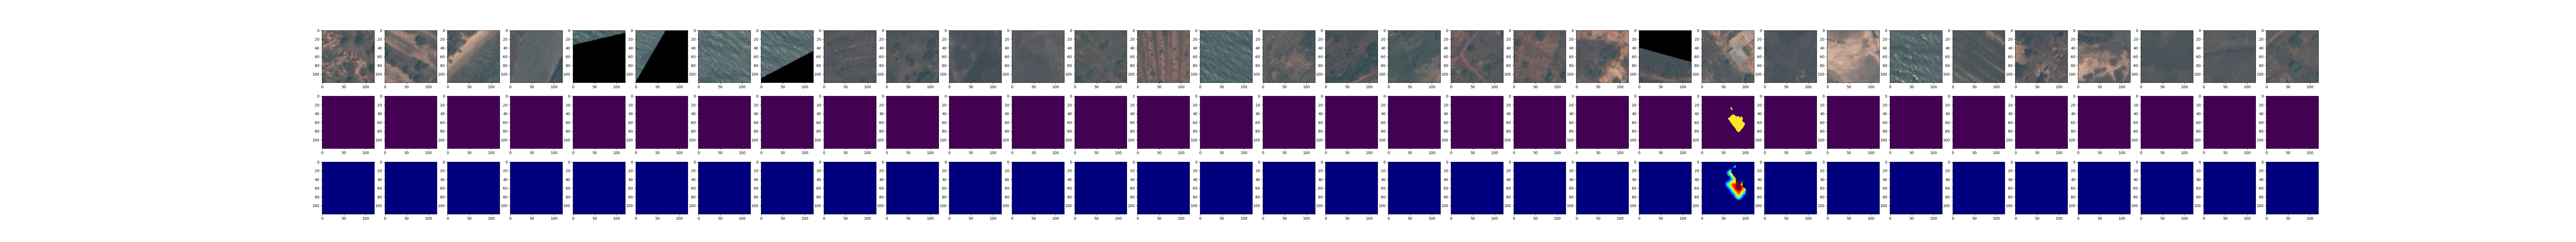

In [4]:
batch_size=32
SAVE_PATCHES=True
test_generator=Dataset_sat.from_root_folder(root_folder+'TEST/',NB_CLASSES)

test_loader = DataLoader(test_generator, batch_size=batch_size,shuffle=True, num_workers=1)


##
all_prediction_path='TEST_SET_GHANA/'
if not os.path.exists(all_prediction_path):
    os.makedirs(all_prediction_path)


predict_net=Train_or_Predict(iter(test_loader).next(),DISTANCE_NET,LOSS_FN,THRESHOLD,BINS,model)

if DISTANCE_NET=='v2':
    probs_dist,probs_seg=predict_net.predict(predict_net.initialize_input())
    prediction_seg_v=probs_seg.data.cpu().numpy()
    probs_dist_v=probs_dist.data.cpu().numpy()
else:
    probs_seg=predict_net.predict(predict_net.initialize_input())
    prediction_seg_v=probs_seg.data.cpu().numpy()

batch_x=np.asarray(predict_net.batch_x)
plot_patches=Plot_patches(prediction_seg_v,groundtruth_seg=None,prediction_dist=probs_dist_v,groundtruth_dist=None)    
plot_patches.plot_patches_only_pred(batch_x,all_prediction_path,SAVE_PATCHES)
